In [2]:
from torch import nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [3]:
import tensorwatch as tw

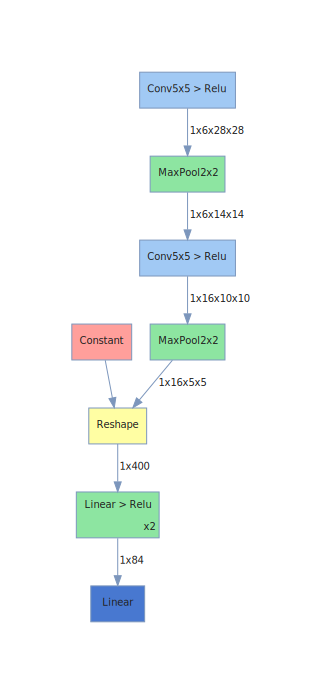

In [4]:
tw.draw_model(net, [1, 3, 32, 32])

In [1]:
import torch

In [2]:
torch.__version__

'1.1.0'

In [1]:
import graphviz

In [5]:
import numpy as np
import torch.nn as nn
import torch.utils.data as Data
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from scipy import interpolate
from scipy import fftpack
import scipy.stats as stats
from scipy.fftpack import fft
from torch.nn import functional
from scipy.signal import butter, filtfilt
import scipy.signal as signal
import scipy.io as scio
import torch
import scipy
import pandas as pd
from sklearn.preprocessing import normalize
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix
import time

class ResidualBlock_1d(nn.Module):
    '''
    residual block small
    '''

    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock_1d, self).__init__()
        self.left = nn.Sequential(
            nn.Conv1d(inchannel, outchannel, 3, stride, 1, bias=False),
            nn.BatchNorm1d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv1d(outchannel, outchannel, 3, 1, 1, bias=False),
            nn.BatchNorm1d(outchannel)
        )
        if inchannel == outchannel:
            self.right = None
        else:
            self.right = nn.Sequential(
                nn.Conv1d(inchannel, outchannel, 1, stride, bias=False),
                nn.BatchNorm1d(outchannel))

    def forward(self, x):
        out = self.left(x)
        if self.right is None:
            residual = x
        else:
            residual = self.right(x)
        out += residual
        return functional.relu(out)


class InceptionC_1d_improve(nn.Module):
    def __init__(self, in_channels, channels_7x7=16):
        super(InceptionC_1d_improve, self).__init__()
        self.branch5_1 = nn.Sequential(nn.Conv1d(in_channels, 6, kernel_size=1),
                                       nn.BatchNorm1d(6),
                                       nn.ReLU(inplace=True))
        self.branch5_2 = nn.Sequential(nn.Conv1d(6, 6, kernel_size=5, padding=2, stride=2),
                                       nn.BatchNorm1d(6),
                                       nn.ReLU(inplace=True))

        self.branch3dbl_1 = nn.Sequential(nn.Conv1d(in_channels, 8, kernel_size=1),
                                          nn.BatchNorm1d(8),
                                          nn.ReLU(inplace=True))
        self.branch3dbl_2 = nn.Sequential(nn.Conv1d(8, 12, kernel_size=3, padding=1),
                                          nn.BatchNorm1d(12),
                                          nn.ReLU(inplace=True))
        self.branch3dbl_3 = nn.Sequential(nn.Conv1d(12, 12, kernel_size=3, padding=1, stride=2),
                                          nn.BatchNorm1d(12),
                                          nn.ReLU(inplace=True))

        self.branch1x1 = nn.Sequential(nn.Conv1d(in_channels, 8, kernel_size=1, stride=2),
                                       nn.BatchNorm1d(8),
                                       nn.ReLU(inplace=True))

        c7 = channels_7x7
        self.branch7x7_1 = nn.Sequential(nn.Conv1d(in_channels, c7, kernel_size=1),
                                         nn.BatchNorm1d(c7),
                                         nn.ReLU(inplace=True))
        self.branch7x7_2 = nn.Sequential(nn.Conv1d(c7, c7, kernel_size=7, padding=3),
                                         nn.BatchNorm1d(c7),
                                         nn.ReLU(inplace=True))
        self.branch7x7_3 = nn.Sequential(nn.Conv1d(c7, 8, kernel_size=7, padding=3, stride=2),
                                         nn.BatchNorm1d(8),
                                         nn.ReLU(inplace=True))
        self.branch7x7dbl_1 = nn.Sequential(nn.Conv1d(in_channels, c7, kernel_size=1),
                                            nn.BatchNorm1d(c7),
                                            nn.ReLU(inplace=True))
        self.branch7x7dbl_2 = nn.Sequential(nn.Conv1d(c7, c7, kernel_size=7, padding=3),
                                            nn.BatchNorm1d(c7),
                                            nn.ReLU(inplace=True))
        self.branch7x7dbl_3 = nn.Sequential(nn.Conv1d(c7, c7, kernel_size=7, padding=3),
                                            nn.BatchNorm1d(c7),
                                            nn.ReLU(inplace=True))
        self.branch7x7dbl_4 = nn.Sequential(nn.Conv1d(c7, c7, kernel_size=7, padding=3),
                                            nn.BatchNorm1d(c7),
                                            nn.ReLU(inplace=True))
        self.branch7x7dbl_5 = nn.Sequential(nn.Conv1d(c7, 8, kernel_size=7, padding=3, stride=2),
                                            nn.BatchNorm1d(8),
                                            nn.ReLU(inplace=True))
        self.branch_pool = nn.Sequential(nn.Conv1d(in_channels, 8, kernel_size=1, stride=2),
                                         nn.BatchNorm1d(8),
                                         nn.ReLU(inplace=True))

    def forward(self, x):
        branch5 = self.branch5_1(x)
        branch5 = self.branch5_2(branch5)
        branch3dbl = self.branch3dbl_1(x)
        branch3dbl = self.branch3dbl_2(branch3dbl)
        branch3dbl = self.branch3dbl_3(branch3dbl)

        branch1x1 = self.branch1x1(x)

        branch7x7 = self.branch7x7_1(x)
        branch7x7 = self.branch7x7_2(branch7x7)
        branch7x7 = self.branch7x7_3(branch7x7)

        branch7x7dbl = self.branch7x7dbl_1(x)
        branch7x7dbl = self.branch7x7dbl_2(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_3(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_4(branch7x7dbl)
        branch7x7dbl = self.branch7x7dbl_5(branch7x7dbl)

        branch_pool = functional.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5, branch3dbl, branch7x7, branch7x7dbl, branch_pool]
        return torch.cat(outputs, 1)

class AttentionModule1d_four_stage_1d(nn.Module):
    # input size is 1*1024
    def __init__(self, in_channels, out_channels, size1=256, size2=128, size3=64, size4=32):
        super(AttentionModule1d_four_stage_1d, self).__init__()
        self.size1 = size1
        self.size2 = size2
        self.size3 = size3
        self.size4 = size4
        self.first_residual_blocks = ResidualBlock_1d(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock_1d(in_channels, out_channels),
            ResidualBlock_1d(in_channels, out_channels)
        )

        self.mpool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        # 512
        self.softmax1_blocks = ResidualBlock_1d(in_channels, out_channels)

        self.skip1_connection_residual_block = ResidualBlock_1d(in_channels, out_channels)

        self.mpool2 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        # 258
        self.softmax2_blocks = ResidualBlock_1d(in_channels, out_channels)

        self.skip2_connection_residual_block = ResidualBlock_1d(in_channels, out_channels)

        self.mpool3 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        # 128
        self.softmax3_blocks = ResidualBlock_1d(in_channels, out_channels)
        self.skip3_connection_residual_block = ResidualBlock_1d(in_channels, out_channels)
        self.mpool4 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        # 64
        self.softmax4_blocks = nn.Sequential(
            ResidualBlock_1d(in_channels, out_channels),
            ResidualBlock_1d(in_channels, out_channels)
        )
        self.softmax5_blocks = ResidualBlock_1d(in_channels, out_channels)
        self.softmax6_blocks = ResidualBlock_1d(in_channels, out_channels)
        self.softmax7_blocks = ResidualBlock_1d(in_channels, out_channels)
        # nn.upsample
        self.softmax8_blocks = nn.Sequential(
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.Sigmoid()
        )
        self.last_blocks = ResidualBlock_1d(in_channels, out_channels)

    def forward(self, x):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        #         print("out_trunk", out_trunk.shape)

        out_mpool1 = self.mpool1(x)
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        #         print("out_softmax1", out_softmax1.shape)
        out_skip1_connection = self.skip1_connection_residual_block(out_softmax1)
        out_mpool2 = self.mpool2(out_softmax1)
        out_softmax2 = self.softmax2_blocks(out_mpool2)
        #         print("out_softmax2", out_softmax2.shape)

        out_skip2_connection = self.skip2_connection_residual_block(out_softmax2)
        out_mpool3 = self.mpool3(out_softmax2)
        out_softmax3 = self.softmax3_blocks(out_mpool3)
        #         print("out_softmax3", out_softmax3.shape)

        out_skip3_connection = self.skip3_connection_residual_block(out_softmax3)
        out_mpool4 = self.mpool4(out_softmax3)
        out_softmax4 = self.softmax4_blocks(out_mpool4)
        #         print("out_softmax4", out_softmax4.shape)#         64, 256, 16

        out_interp4 = nn.functional.interpolate(input=out_softmax4, size=self.size4) + out_softmax3

        out = out_interp4 + out_skip3_connection
        out_softmax5 = self.softmax5_blocks(out)
        out_interp3 = nn.functional.interpolate(input=out_softmax5, size=self.size3) + out_softmax2

        out = out_interp3 + out_skip2_connection

        out_softmax6 = self.softmax6_blocks(out)

        out_interp2 = nn.functional.interpolate(input=out_softmax6, size=self.size2) + out_softmax1
        out = out_interp2 + out_skip1_connection
        out_softmax7 = self.softmax7_blocks(out)
        out_interp1 = nn.functional.interpolate(input=out_softmax7, size=self.size1) + out_trunk
        out_softmax8 = self.softmax8_blocks(out_interp1)
        out = (1 + out_softmax8) * out_trunk
        out_last = self.last_blocks(out)
        out_last = functional.dropout(out_last, p=0.2, training=self.training)
        return out_last


class ResidualAttentionModel_1d_two_attention_with_inceptionC_improve(nn.Module):
    # for input size 1024
    def __init__(self, classnumber):
        super(ResidualAttentionModel_1d_two_attention_with_inceptionC_improve, self).__init__()
        self.InceptionC_1d = InceptionC_1d_improve(in_channels=1)
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True))
        self.mpool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(58, 16, 3)

        self.attention_module1 = AttentionModule1d_four_stage_1d(16, 16)

        self.layer2 = self._make_layer(16, 32, 3)
        self.attention_module2 = AttentionModule1d_four_stage_1d(32, 32)

        self.layer3 = self._make_layer(32, 64, 3, stride=2)

        self.mpool2 = nn.Sequential(
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=7, stride=1)
        )
        self.fc = nn.Linear(7808, classnumber)

    def _make_layer(self, inchannel, outchannel, block_num, stride=1):
        """
        构建layer,包含多个residual block
        """
        layers = []
        layers.append(ResidualBlock_1d(inchannel, outchannel, stride))
        #         at least one
        for i in range(1, block_num):
            layers.append(ResidualBlock_1d(outchannel, outchannel))
        return nn.Sequential(*layers)

    def forward(self, x):
        x_inception = self.InceptionC_1d(x)
        out = self.conv1(x)
        out = torch.cat([x_inception, out], 1)
        out = self.mpool1(out)
        out = functional.dropout(out, p=0.1, training=self.training)
        out = self.layer1(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        out = self.attention_module1(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        out = self.layer2(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        out = self.attention_module2(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        out = self.layer3(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        out = self.mpool2(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out



# ---------------
# 对照测试网络
class AttentionModule1d_no_stage_1d(nn.Module):
    # input size is 1*1024
    def __init__(self, in_channels, out_channels, size1=256, size2=128, size3=64, size4=32):
        super(AttentionModule1d_no_stage_1d, self).__init__()
        self.size1 = size1
        self.size2 = size2
        self.size3 = size3
        self.size4 = size4

        self.first_residual_blocks = ResidualBlock_1d(in_channels, out_channels)

        self.trunk_branches = nn.Sequential(
            ResidualBlock_1d(in_channels, out_channels),
            ResidualBlock_1d(in_channels, out_channels)
        )

        self.mpool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        # 512
        self.softmax1_blocks = ResidualBlock_1d(in_channels, out_channels)

        self.softmax8_blocks = nn.Sequential(
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.Sigmoid()
        )
        self.last_blocks = ResidualBlock_1d(in_channels, out_channels)

    def forward(self, x):
        x = self.first_residual_blocks(x)
        out_trunk = self.trunk_branches(x)
        #         print("out_trunk", out_trunk.shape)

        out_mpool1 = self.mpool1(x)
        out_softmax1 = self.softmax1_blocks(out_mpool1)
        #         print("out_softmax1", out_softmax1.shape)

        out_interp1 = nn.functional.interpolate(input=out_softmax1, size=self.size1) + out_trunk
        out_softmax8 = self.softmax8_blocks(out_interp1)
        out = (1 + out_softmax8) * out_trunk
        out_last = self.last_blocks(out)
        return out_last


class ResidualAttentionModel_1d_two_attention_with_inceptionC_improve_duizhao(nn.Module):
    # for input size 1024
    # 对照网络, No stage
    def __init__(self, classnumber):
        super(ResidualAttentionModel_1d_two_attention_with_inceptionC_improve_duizhao, self).__init__()
        self.InceptionC_1d = InceptionC_1d_improve(in_channels=1)
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(8),
            nn.ReLU(inplace=True))
        self.mpool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(58, 16, 3)

        self.attention_module1 = AttentionModule1d_no_stage_1d(16, 16)

        self.layer2 = self._make_layer(16, 32, 3)
        self.attention_module2 = AttentionModule1d_no_stage_1d(32, 32)

        self.layer3 = self._make_layer(32, 64, 3, stride=2)

        self.mpool2 = nn.Sequential(
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.AvgPool1d(kernel_size=7, stride=1)
        )
        self.fc = nn.Linear(7808, classnumber)

    def _make_layer(self, inchannel, outchannel, block_num, stride=1):
        """
        构建layer,包含多个residual block
        """
        layers = []
        layers.append(ResidualBlock_1d(inchannel, outchannel, stride))
        #         at least one
        for i in range(1, block_num):
            layers.append(ResidualBlock_1d(outchannel, outchannel))
        return nn.Sequential(*layers)

    def forward(self, x):
        x_inception = self.InceptionC_1d(x)
        out = self.conv1(x)
        out = torch.cat([x_inception, out], 1)
        out = self.mpool1(out)
        out = functional.dropout(out, p=0.1, training=self.training)
        out = self.layer1(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        out = self.attention_module1(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        out = self.layer2(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        out = self.attention_module2(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        out = self.layer3(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        out = self.mpool2(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


# 对照网络1
class LuResNet_1D(nn.Module):
    def __init__(self, classnumber):
        super(LuResNet_1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=9, padding=4)
        self.shortcut1 = nn.Conv1d(1, 8, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(8)
        self.mpool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.shortcut2 = nn.Conv1d(8, 16, kernel_size=1)
        self.conv2 = nn.Conv1d(8, 16, kernel_size=9, padding=4)
        self.bn2 = nn.BatchNorm1d(16)
        self.mpool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.conv3 = nn.Conv1d(16, 32, kernel_size=9, padding=4)
        self.bn3 = nn.BatchNorm1d(32)
        self.mpool3 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.dense = nn.Linear(512, classnumber)

    def forward(self, x):
        x_short1 = self.shortcut1(x)
        out = self.conv1(x)
        out = out + x_short1
        #         N, 8, 1024
        out = functional.leaky_relu(self.bn1(out))
        out = self.mpool1(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        #         10, 8, 256
        x_short2 = self.shortcut2(out)
        out = self.conv2(out)
        out = out + x_short2
        out = functional.leaky_relu(self.bn2(out))
        out = self.mpool2(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        out = self.conv3(out)
        out = functional.leaky_relu(self.bn3(out))
        out = self.mpool3(out)
        out = functional.dropout(out, p=0.3, training=self.training)
        out = out.view(out.size(0), -1)
        out = self.dense(out)
        return out


class AcharyaNet(nn.Module):
    # Deep convolutional neural network for the automated detection and diagnosis of seizure using EEG signals
    def __init__(self, classnumber):
        super(AcharyaNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 4, kernel_size=6, stride=1)
        self.mpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(4, 4, kernel_size=5, stride=1)
        self.mpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv1d(4, 10, kernel_size=4, stride=1)
        self.mpool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv1d(10, 10, kernel_size=4, stride=1)
        self.mpool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv1d(10, 15, kernel_size=4, stride=1)
        self.mpool5 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.dense1 = nn.Linear(280, 50)
        self.dense2 = nn.Linear(50, 20)
        self.dense3 = nn.Linear(20, 3)

    def forward(self, x):
        out = self.conv1(x)
        out = self.mpool1(out)
        out = self.conv2(out)
        out = self.mpool2(out)
        out = self.conv3(out)
        out = self.mpool3(out)
        out = self.conv4(out)
        out = self.mpool4(out)
        out = self.conv4(out)
        out = self.mpool4(out)
        out = out.view(out.size(0), -1)
        out = self.dense1(out)
        out = self.dense2(out)
        out = self.dense3(out)
        return out


In [7]:
m = ResidualAttentionModel_1d_two_attention_with_inceptionC_improve(classnumber=2)

In [10]:
t = tw.draw_model(m, [1, 1, 1024])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/torch/onnx/utils.py:586: UserWarning: ONNX export failed on ATen operator upsample_nearest1d because torch.onnx.symbolic.upsample_nearest1d does not exist
  .format(op_name, op_name))


In [12]:
t.save("ResidualAttentionModel_1d_two_attention_with_inceptionC_improve.png")